# Wykorzystanie rozkładów macierzy do rozwiązywania oznaczonych układów równań

Poznane na wykładzie rozkłady (faktoryzacje) macierzy możemy wykorzystać do rozwiązywania układów równań liniowych. Dzięki wykorzystaniu specjalnych własności macierzy występujących w rozkładzie jesteśmy w stanie w łatwiejszy sposób odwrócić macierz i tym samym zminimalizować błąd.


**Zadanie 1.**

Rozważmy układ równań $Ax=b$, w którym:
* $A$ jest macierzą Hilberta o wymiarach 15x15.
* $A$ jest macierzą wartości losowych z przedziału $[0,100]$ o wymiarach 100x100,  1000x1000 i 1000000x1000000.
* $b$ jest wektorem wartości losowych, odpowiednio, o wymiarach 15x1, 100x1, 1000x1 i 1000000x1.

1. Oblicz współczynnik uwarunkowania macierzy $A$ i oceń jej uwarunkowanie.
2. Rozwiąż układ równań następującymi metodami:
    * z użyciem jawnej odwrotności $A$.
    * korzystając z rozkładu [LU](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu.html) (uwaga na macierz permutacji!):
        * z wykorzystaniem odwrotności L i U.
        * z użyciem jedynie odwrotności i metody podstawiania wstecznego.
    * korzystając z rozkładu [QR](https://numpy.org/doc/stable/reference/generated/numpy.linalg.qr.html):
        * z wykorzystaniem odwrotności Q i R.
        * z użyciem jedynie odwrotności Q i metody podstawiania wstecznego.
    * za pomocą jednej z metod iteracyjnych z poprzedniego ćwiczenia.
    * za pomocą metody [`solve`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html) z pakietu NumPy.
3. Porównaj otrzymane wyniki. W tym celu oblicz normy z residuuów otrzymanych dla każdego z rozwiązań. Którą z metod cechuje najwyższa dokladność?
4. Przeprowadź porównanie wydajności ww. metod. Zmierz czas wykonania każdej metody. Aby otrzymać bardziej sensowny wynik należy powtórzyć obliczenia w pętli (np. 100 lub 1000 razy) i uśrednić wynik. Do pomiaru czasu wykonania możesz wykorzystać pakiet `time`.
Wskazówka: Do rozwiązania układu z macierzą trójkątną możesz wykorzystać funkcję [`scipy.linalg.solve_triangular`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_triangular.html).

        
        


In [4]:
import numpy as np
from scipy.linalg import hilbert, lu, solve_triangular
from numpy.linalg import solve, inv, norm, qr, cond
import time

def jacobi(A, b, x0=None, max_iter=500, tol=1e-10):
    n = A.shape[0]
    x = np.zeros_like(b) if x0 is None else x0.copy()
    D = np.diag(A)
    R = A - np.diagflat(D)
    for _ in range(max_iter):
        x_new = (b - R @ x) / D
        if norm(x_new - x) < tol:
            break
        x = x_new
    return x

def test_methods(A, b, iters=5):
    results_residual = {}
    results_time = {}

    # Inverse method
    start = time.time()
    for _ in range(iters):
        x_inv = inv(A) @ b
    end = time.time()
    results_residual['Inverse'] = norm(A @ x_inv - b)
    results_time['Inverse'] = (end - start) / iters

    # LU decomposition
    P, L, U = lu(A)

    # LU with inverse
    start = time.time()
    for _ in range(iters):
        y = inv(L) @ (P @ b)
        x_lu_inv = inv(U) @ y
    end = time.time()
    results_residual['LU (inv)'] = norm(A @ x_lu_inv - b)
    results_time['LU (inv)'] = (end - start) / iters

    # LU with triangular solve
    start = time.time()
    for _ in range(iters):
        y = solve_triangular(L, P @ b, lower=True)
        x_lu_tri = solve_triangular(U, y)
    end = time.time()
    results_residual['LU (tri solve)'] = norm(A @ x_lu_tri - b)
    results_time['LU (tri solve)'] = (end - start) / iters

    # QR decomposition
    Q, R = qr(A)

    # QR with inverse
    start = time.time()
    for _ in range(iters):
        x_qr_inv = inv(R) @ (Q.T @ b)
    end = time.time()
    results_residual['QR (inv)'] = norm(A @ x_qr_inv - b)
    results_time['QR (inv)'] = (end - start) / iters

    # QR with triangular solve
    start = time.time()
    for _ in range(iters):
        y = Q.T @ b
        x_qr_tri = solve_triangular(R, y)
    end = time.time()
    results_residual['QR (tri solve)'] = norm(A @ x_qr_tri - b)
    results_time['QR (tri solve)'] = (end - start) / iters

    # Jacobi iterative method
    start = time.time()
    for _ in range(iters):
        x_jacobi = jacobi(A, b)
    end = time.time()
    results_residual['Jacobi'] = norm(A @ x_jacobi - b)
    results_time['Jacobi'] = (end - start) / iters

    # Numpy solve
    start = time.time()
    for _ in range(iters):
        x_np = solve(A, b)
    end = time.time()
    results_residual['np.linalg.solve'] = norm(A @ x_np - b)
    results_time['np.linalg.solve'] = (end - start) / iters

    # Condition number
    condition = cond(A)

    return condition, results_residual, results_time

# ====================
# Przypadek: Hilbert 15x15
# ====================
np.random.seed(0)
A_hilbert = hilbert(15)
b_hilbert = np.random.rand(15)

print("=== MACIERZ HILBERTA 15x15 ===")
condition, residuals, times = test_methods(A_hilbert, b_hilbert)
print(f"Wskaźnik uwarunkowania: {condition:.2e}")
print("\nNormy residuum:")
for method, res in residuals.items():
    print(f"{method:20s}: {res:.2e}")
print("\nCzasy średnie (s):")
for method, t in times.items():
    print(f"{method:20s}: {t:.5f}")

# ====================
# Przypadek: Losowa 100x100
# ====================
print("\n=== MACIERZ LOSOWA 100x100 ===")
A_rand = np.random.rand(100, 100) * 100
b_rand = np.random.rand(100)
condition, residuals, times = test_methods(A_rand, b_rand)
print(f"Wskaźnik uwarunkowania: {condition:.2e}")
print("\nNormy residuum:")
for method, res in residuals.items():
    print(f"{method:20s}: {res:.2e}")
print("\nCzasy średnie (s):")
for method, t in times.items():
    print(f"{method:20s}: {t:.5f}")


=== MACIERZ HILBERTA 15x15 ===
Wskaźnik uwarunkowania: 3.68e+17

Normy residuum:
Inverse             : 2.89e+00
LU (inv)            : 1.13e+00
LU (tri solve)      : 1.19e+00
QR (inv)            : 8.99e-01
QR (tri solve)      : 1.04e+00
Jacobi              : nan
np.linalg.solve     : 9.26e-01

Czasy średnie (s):
Inverse             : 0.00080
LU (inv)            : 0.00000
LU (tri solve)      : 0.00000
QR (inv)            : 0.00000
QR (tri solve)      : 0.00000
Jacobi              : 0.00360
np.linalg.solve     : 0.00000

=== MACIERZ LOSOWA 100x100 ===
Wskaźnik uwarunkowania: 6.97e+03

Normy residuum:
Inverse             : 2.71e-13
LU (inv)            : 4.58e+00
LU (tri solve)      : 4.58e+00
QR (inv)            : 5.59e-14
QR (tri solve)      : 5.55e-14
Jacobi              : nan
np.linalg.solve     : 8.26e-14

Czasy średnie (s):
Inverse             : 0.00120
LU (inv)            : 0.00320
LU (tri solve)      : 0.00000
QR (inv)            : 0.00160
QR (tri solve)      : 0.00000
Jacobi       

C:\Users\karol\AppData\Local\Temp\ipykernel_19748\4073998309.py:12: RuntimeWarning: overflow encountered in divide
  x_new = (b - R @ x) / D
C:\Users\karol\AppData\Local\Temp\ipykernel_19748\4073998309.py:12: RuntimeWarning: invalid value encountered in matmul
  x_new = (b - R @ x) / D
C:\Users\karol\AppData\Local\Temp\ipykernel_19748\4073998309.py:12: RuntimeWarning: overflow encountered in matmul
  x_new = (b - R @ x) / D


# Interpolacja

**Zadanie 2.**

Przeprowadź interpolacje poniższych funkcji $f(x)$ za pomocą wielomianów interpolacyjnych Lagrange'a ([`scipy.interpolate.lagrange`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.lagrange.html)). Stwórz wykresy funkcji interpolacyjnych i zaznacz na nich punkty, w ktorych dokonano oceny wartości funkcji.

Pierwsza funkcja:

* $f(0) = 1$,
* $f(0.25) = 1.64872$,
* $f(0.5) = 2.71828$,
* $f(0.75) = 4.48169.$

Oblicz $f(0.43)$.

Druga funkcja:

* $f_2(0.1) = 0.62049958$,
* $f_2(0.2) = -0.28398668$,
* $f_2(0.3) = 0.00660095$,
* $f_2(0.4) = 0.24842440$. 

Oblicz $f_2(0.25)$.

Wartość funkcji f(0.43) ≈ 2.360605


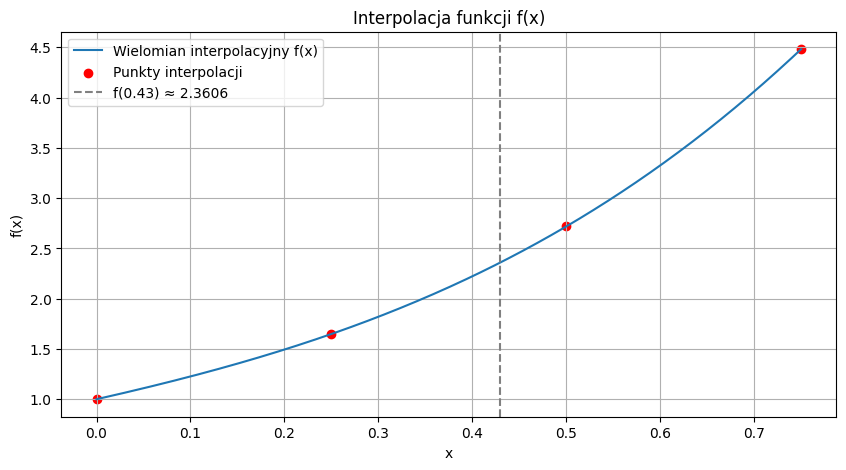

Wartość funkcji f₂(0.25) ≈ -0.210337


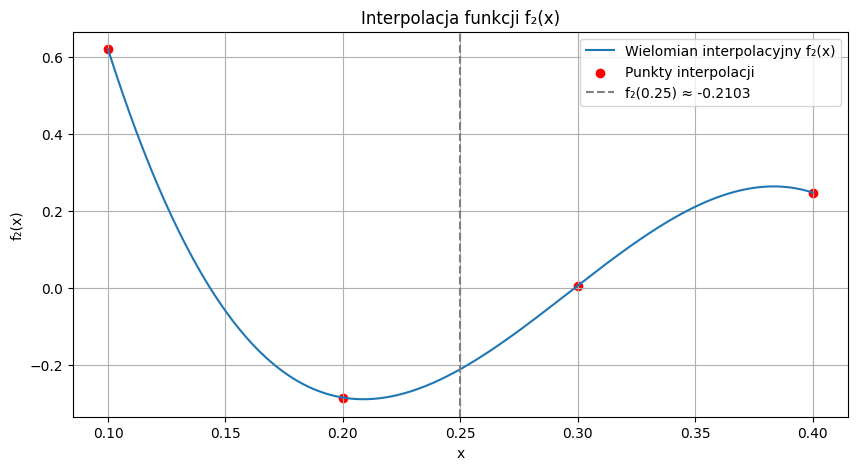

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange

# === Funkcja 1 ===
x1 = np.array([0, 0.25, 0.5, 0.75])
y1 = np.array([1, 1.64872, 2.71828, 4.48169])

# Interpolacja Lagrange’a
poly1 = lagrange(x1, y1)

# Obliczenie wartości w x = 0.43
x_eval_1 = 0.43
y_eval_1 = poly1(x_eval_1)
print(f"Wartość funkcji f(0.43) ≈ {y_eval_1:.6f}")

# Wykres
x_plot_1 = np.linspace(0, 0.75, 300)
y_plot_1 = poly1(x_plot_1)

plt.figure(figsize=(10, 5))
plt.plot(x_plot_1, y_plot_1, label="Wielomian interpolacyjny f(x)")
plt.scatter(x1, y1, color='red', label="Punkty interpolacji")
plt.axvline(x=x_eval_1, linestyle='--', color='gray', label=f"f(0.43) ≈ {y_eval_1:.4f}")
plt.title("Interpolacja funkcji f(x)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()

# === Funkcja 2 ===
x2 = np.array([0.1, 0.2, 0.3, 0.4])
y2 = np.array([0.62049958, -0.28398668, 0.00660095, 0.24842440])

# Interpolacja Lagrange’a
poly2 = lagrange(x2, y2)

# Obliczenie wartości w x = 0.25
x_eval_2 = 0.25
y_eval_2 = poly2(x_eval_2)
print(f"Wartość funkcji f₂(0.25) ≈ {y_eval_2:.6f}")

# Wykres
x_plot_2 = np.linspace(0.1, 0.4, 300)
y_plot_2 = poly2(x_plot_2)

plt.figure(figsize=(10, 5))
plt.plot(x_plot_2, y_plot_2, label="Wielomian interpolacyjny f₂(x)")
plt.scatter(x2, y2, color='red', label="Punkty interpolacji")
plt.axvline(x=x_eval_2, linestyle='--', color='gray', label=f"f₂(0.25) ≈ {y_eval_2:.4f}")
plt.title("Interpolacja funkcji f₂(x)")
plt.xlabel("x")
plt.ylabel("f₂(x)")
plt.legend()
plt.grid(True)
plt.show()


***Zadanie 3.***

Rozważmy funkcję $f(x)=\frac{1}{25x^2+1}$. 

Przeprowadź interpolacje funkcji $f$ w przedziale $[-2,2]$ wielomianem Lagrange'a oraz funkcjami sklejanymi 3 stopnia w:
- 21 równoodległych węzłach,
- 21 węzłach [Czebyszewa](https://pl.wikipedia.org/wiki/Węzły_Czebyszewa).

**Wskazówka** Interpolację funkcjami sklejanymi możesz przeprowadzić za pomocą funkcji [`interp1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d).

Umieść wielomian interpolacyjny, oryginalną funkcję $f$ oraz węzly interpolacyjne na wspólnym wykresie (jeden wykres dla metody Lagrange'a oraz jeden dla funkcji sklejanych). Porównaj otrzymane rezultaty. Przeprowadź te same działania dla przedziału $x\in[-5,5]$. Jakie problemy możesz zauważyć na otrzymanych wykresach?

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange, interp1d

# Funkcja docelowa
def f(x):
    return 1 / (25 * x**2 + 1)

# Węzły Czebyszewa w przedziale [a, b]
def chebyshev_nodes(n, a, b):
    k = np.arange(1, n + 1)
    x_cheb = np.cos((2 * k - 1) * np.pi / (2 * n))
    return 0.5 * (a + b) + 0.5 * (b - a) * x_cheb[::-1]

# Funkcja rysująca wykresy
def plot_interpolation(a, b, title_suffix=""):
    x_dense = np.linspace(a, b, 1000)
    y_true = f(x_dense)

    # Równoodległe węzły
    x_uniform = np.linspace(a, b, 21)
    y_uniform = f(x_uniform)

    # Czebyszewowskie węzły
    x_cheb = chebyshev_nodes(21, a, b)
    y_cheb = f(x_cheb)

    # Interpolacja Lagrange’a
    poly_uniform = lagrange(x_uniform, y_uniform)
    poly_cheb = lagrange(x_cheb, y_cheb)

    # Interpolacja funkcjami sklejanymi
    spline_uniform = interp1d(x_uniform, y_uniform, kind='cubic')
    spline_cheb = interp1d(x_cheb, y_cheb, kind='cubic')

    # Obliczenia
    y_lagr_uniform = poly_uniform(x_dense)
    y_lagr_cheb = poly_cheb(x_dense)
    y_spline_uniform = spline_uniform(x_dense)
    y_spline_cheb = spline_cheb(x_dense)

    # === Wykres Lagrange’a ===
    plt.figure(figsize=(12, 5))
    plt.plot(x_dense, y_true, label="f(x)", linewidth=2)
    plt.plot(x_dense, y_lagr_uniform, '--', label="Lagrange (równoodległe)", color='red')
    plt.plot(x_dense, y_lagr_cheb, '--', label="Lagrange (Czebyszewa)", color='green')
    plt.scatter(x_uniform, y_uniform, color='red', s=30)
    plt.scatter(x_cheb, y_cheb, color='green', s=30)
    plt.title(f"Interpolacja Lagrange'a {title_suffix}")
    plt.legend()
    plt.grid(True)
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.ylim(-0.2, 1.2)
    plt.show()

    # === Wykres funkcji sklejanych ===
    plt.figure(figsize=(12, 5))
    plt.plot(x_dense, y_true, label="f(x)", linewidth=2)
    plt.plot(x_dense, y_spline_uniform, '--', label="Spline (równoodległe)", color='blue')
    plt.plot(x_dense, y_spline_cheb, '--', label="Spline (Czebyszewa)", color='orange')
    plt.scatter(x_uniform, y_uniform, color='blue', s=30)
    plt.scatter(x_cheb, y_cheb, color='orange', s=30)
    plt.title(f"Interpolacja funkcjami sklejanymi {title_suffix}")
    plt.legend()
    plt.grid(True)
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.ylim(-0.2, 1.2)
    plt.show()

# === Przedział [-2, 2] ===
plot_interpolation(-2, 2, title_suffix="dla przedziału [-2, 2]")

# === Przedział [-5, 5] ===
plot_interpolation(-5, 5, title_suffix="dla przedziału [-5, 5]")


ValueError: A value (-2.0) in x_new is below the interpolation range's minimum value (-1.9944075943623603).

***Zadanie 4.***

Kierowca jadący z miasta A do miasta B, zauważywszy na drodze fotoradar, zaczął gwałtownie hamować. Przebieg jego położenia, zarejestrowany przez nawigację, pokazano w poniższej tabeli. Wiedząc, że radar znajduje się w punkcie o współrzędnej 79.6 m, oszacuj kiedy kierowca minął fotoradar (w tym celu skorzystaj z jednej z metod z laboratorium 3) oraz z jaką prędkością wtedy jechał (wykorzystaj relację drogi i prędkości znaną z fizyki). 

|czas \[s\]|położenie \[m\]|
|--|--|
|0.0|0.0|
|1.0|42.7|
|2.0|73.2|
|3.0|92.5|

Czas przejazdu przez fotoradar: 2.2758 s
Prędkość w tym momencie: 21.6819 m/s


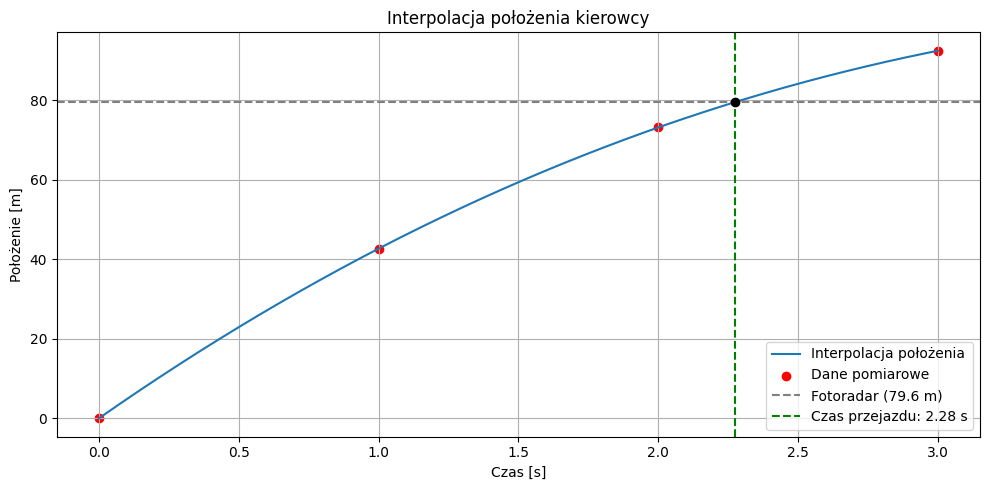

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.optimize import root_scalar

# Dane z tabeli
time = np.array([0.0, 1.0, 2.0, 3.0])  # w sekundach
position = np.array([0.0, 42.7, 73.2, 92.5])  # w metrach

# Interpolacja funkcją sklejaną 3. stopnia
spline = CubicSpline(time, position)

# Cel: pozycja = 79.6 m, czyli znalezienie t: spline(t) = 79.6
def position_difference(t):
    return spline(t) - 79.6

# Szukamy miejsca przecięcia w przedziale (2, 3)
sol = root_scalar(position_difference, bracket=[2.0, 3.0], method='brentq')
t_radar = sol.root

# Obliczenie prędkości jako pochodnej funkcji położenia
spline_derivative = spline.derivative()
v_radar = spline_derivative(t_radar)

# Wyniki
print(f"Czas przejazdu przez fotoradar: {t_radar:.4f} s")
print(f"Prędkość w tym momencie: {v_radar:.4f} m/s")

# Wizualizacja
t_dense = np.linspace(0, 3, 500)
pos_dense = spline(t_dense)

plt.figure(figsize=(10, 5))
plt.plot(t_dense, pos_dense, label="Interpolacja położenia")
plt.scatter(time, position, color='red', label="Dane pomiarowe")
plt.axhline(79.6, color='gray', linestyle='--', label="Fotoradar (79.6 m)")
plt.axvline(t_radar, color='green', linestyle='--', label=f"Czas przejazdu: {t_radar:.2f} s")
plt.scatter(t_radar, 79.6, color='black', zorder=5)
plt.title("Interpolacja położenia kierowcy")
plt.xlabel("Czas [s]")
plt.ylabel("Położenie [m]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**Zadanie dla zainteresowanych programowaniem funkcyjnym w Pythonie**

Stwórz funkcję znajdującą wielomian interpolacyjny metodą Lagrange'a. Funkcja powinna przyjmować dwie listy:
* listę argumentów ($x$-ów)
* listę wartości ($y$-ów).  


Po wykonaniu obliczeń funkcja powinna zwracać wielomian w postaci obiektu typu **funkcja** (a nie `numpy.Polynomial`).

**Wskazówka** Wykorzystaj wyrażenia *lambda*. Dla ułatwienia możesz się też posłużyć pakietami `operator` i `functools`.


In [3]:
from functools import reduce
from operator import mul

def lagrange_interpolator(x_points, y_points):
    """
    Zwraca funkcję lambda reprezentującą wielomian interpolacyjny Lagrange’a.
    """
    def L(k, x):
        # Iloczyn (x - xj) / (xk - xj) dla j != k
        return reduce(mul, [(x - xj) / (x_points[k] - xj) for j, xj in enumerate(x_points) if j != k], 1)

    return lambda x: sum(yk * L(k, x) for k, yk in enumerate(y_points))

# Przykład użycia
x_vals = [0, 1, 2]
y_vals = [1, 3, 2]

# Tworzymy wielomian
poly = lagrange_interpolator(x_vals, y_vals)

# Sprawdzamy wynik
print(f"f(1.5) = {poly(1.5)}")
print(f"f(0.0) = {poly(0.0)}")  # powinno być 1
print(f"f(1.0) = {poly(1.0)}")  # powinno być 3
print(f"f(2.0) = {poly(2.0)}")  # powinno być 2


f(1.5) = 2.875
f(0.0) = 1.0
f(1.0) = 3.0
f(2.0) = 2.0
